## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from fredapi import Fred
import tensorflow as tf
from tensorflow.keras import layers, Model, backend as K
from tensorflow.keras.losses import mse
from sklearn.preprocessing import StandardScaler
from scipy.stats import wasserstein_distance, ks_2samp, entropy
from sklearn.cluster import KMeans

2025-03-01 15:07:06.817003: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-01 15:07:06.827358: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740859626.837136  325969 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740859626.840027  325969 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-01 15:07:06.851368: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## Data

### Parameters

In [ ]:
tickers = [
    "AAPL",
    "BAC",
    "KO",
    "AXP",
    "WFC",
    "KHC",
    "JPM",
    "USB",
    "MCO",
    "DAL",
    "BK",
    "LUV",
    "DVA",
    "GS",
    "GM",
    "CHTR",
    "VRSN",
    "V",
    "UAL",
    "MA",
    "PNC",
    "COST",
    "AAL",
    "AMZN",
    "SIRI",
    "MTB",
    "OXY",
    "SYF",
    "AXTA",
    "GL",
    "STNE",
    "KR",
    "QSR",
    "SU",
    "LBTYA",
    "TEVA",
    "RH",
    "BIIB",
    "LBTYK",
    "LILA",
    "JNJ",
    "TRV",
    "PG",
    "MDLZ",
    "PSX",
    "LILAK",
    "VOO",
    "SPY",
    "UPS",
]

start_date = "2000-01-01"
end_date = "2021-01-01"

### Download Market Data

In [3]:
data = yf.download(tickers, start=start_date, end=end_date, progress=False)
data

YF.download() has changed argument auto_adjust default to True


Price           Close                                                 \
Ticker            AAL        AAPL        AMZN         AXP       AXTA   
Date                                                                   
2000-01-03        NaN    0.842150    4.468750   32.595181        NaN   
2000-01-04        NaN    0.771149    4.096875   31.364424        NaN   
2000-01-05        NaN    0.782433    3.487500   30.567801        NaN   
2000-01-06        NaN    0.714723    3.278125   31.190565        NaN   
2000-01-07        NaN    0.748579    3.478125   31.644669        NaN   
...               ...         ...         ...         ...        ...   
2020-12-24  15.660000  128.905792  158.634506  111.246834  28.760000   
2020-12-28  16.059999  133.516220  164.197998  112.204285  28.379999   
2020-12-29  15.860000  131.738464  166.100006  111.995720  28.280001   
2020-12-30  16.150000  130.615158  164.292496  113.218658  28.559999   
2020-12-31  15.770000  129.609100  162.846497  114.621658  28.549999   

Price                                                                 ...  \
Ticker            BAC        BIIB         BK        CHTR        COST  ...   
Date                                                                  ...   
2000-01-03  12.714028   31.083332  21.912382         NaN   29.851645  ...   
2000-01-04  11.959387   28.979168  21.283140         NaN   28.216515  ...   
2000-01-05  12.090631   31.000000  20.801954         NaN   28.698664  ...   
2000-01-06  13.124156   32.375000  21.320154         NaN   29.275158  ...   
2000-01-07  12.779648   36.104168  22.430569         NaN   31.214270  ...   
...               ...         ...        ...         ...         ...  ...   
2020-12-24  27.166571  248.889999  36.113945  656.489990  346.373840  ...   
2020-12-28  27.320719  244.149994  36.465942  651.900024  352.530334  ...   
2020-12-29  27.211908  243.460007  36.465942  664.979980  354.107361  ...   
2020-12-30  27.184708  243.580002  36.685928  653.489990  355.751038  ...   
2020-12-31  27.483936  244.860001  37.345909  661.549988  357.964661  ...   

Price          Volume                                                   \
Ticker            SYF      TEVA      TRV         UAL      UPS      USB   
Date                                                                     
2000-01-03        NaN   3145600   336400         NaN  1273200  2354200   
2000-01-04        NaN   4314400   494400         NaN  1385800  3687700   
2000-01-05        NaN   3379200   736000         NaN  1401700  2704200   
2000-01-06        NaN   2148000   660400         NaN  1959100  4185300   
2000-01-07        NaN  10913600   594700         NaN   996000  4486700   
...               ...       ...      ...         ...      ...      ...   
2020-12-24   844400.0   3108700   416800   7230600.0  1006100  1980900   
2020-12-28  1903000.0   7786000  1100300  13693200.0  1861700  4330800   
2020-12-29  2217000.0   6494700   859000   9927700.0  2864600  4083400   
2020-12-30  2617500.0   5919500  1253800   9473300.0  3107100  3157400   
2020-12-31  2331600.0   8103700   970200  12684000.0  2349400  3778500   

Price                                                
Ticker              V        VOO     VRSN       WFC  
Date                                                 
2000-01-03        NaN        NaN  2270100   9037000  
2000-01-04        NaN        NaN  3002200  15237200  
2000-01-05        NaN        NaN  6886600   8228200  
2000-01-06        NaN        NaN  4003200   8326800  
2000-01-07        NaN        NaN  3803200   7711200  
...               ...        ...      ...       ...  
2020-12-24  3367900.0  1447500.0   139900  14443700  
2020-12-28  5816200.0  2798800.0   296500  21658500  
2020-12-29  6093400.0  2555500.0   287100  19584400  
2020-12-30  8875100.0  2009100.0   248500  18519300  
2020-12-31  5922200.0  3507000.0   311100  21081200  

[5284 rows x 245 columns]

In [4]:
data = data["Close"].dropna()

returns = np.log(data / data.shift(1)).dropna()

returns_scaler = StandardScaler()
returns_scaled = returns.copy()
returns_scaled.iloc[:] = returns_scaler.fit_transform(returns_scaled)

### Download and Prepare Macroeconomic Indicators

In [ ]:
with open("key_fred.txt", "r") as file:
    key_fred = file.read().strip()

fred = Fred(api_key=key_fred)

inflation = fred.get_series("CPIAUCSL")
fed_funds = fred.get_series("FEDFUNDS")
unemployment = fred.get_series("UNRATE")
short_term = fred.get_series("DGS3MO")
long_term = fred.get_series("DGS10")

In [ ]:
macro_df = pd.concat(
    [inflation, fed_funds, unemployment, short_term, long_term], axis=1
)
macro_df.ffill(inplace=True)
macro_df = macro_df.loc[start_date:end_date]
macro_df.columns = ["inflation", "fed_funds", "unemployment", "short_term", "long_term"]

vix_df = yf.download("^VIX", start=start_date, end=end_date, progress=False)

vix_column = "Adj Close" if "Adj Close" in vix_df.columns else "Close"

if isinstance(vix_df.columns, pd.MultiIndex):
    vix_data = vix_df[("Close", "^VIX")].rename("vix")
else:
    vix_data = vix_df["Close"].rename("vix")

macro_df = pd.concat([macro_df, vix_data], axis=1)
macro_df = macro_df.reindex(returns.index).ffill()

macro_scaler = StandardScaler()
macro_scaled = macro_scaler.fit_transform(macro_df)

## Define custom layers: Sampling, Reconstruction Loss, KL Divergence

In [ ]:
class SamplingLayer(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


class ReconstructionLossLayer(layers.Layer):
    def call(self, inputs):
        x, x_pred = inputs
        loss = K.mean(mse(x, x_pred))
        self.add_loss(loss)
        return x_pred


class KLDivergenceLayer(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        kl_loss = -0.5 * tf.reduce_sum(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1
        )
        self.add_loss(tf.reduce_mean(kl_loss))
        return z_mean

## Conditional VAE: Unconditioned Encoder, Conditioned Decoder with Dropout

In [ ]:
def build_conditional_vae(input_dim, macro_dim, intermediate_dim=256, latent_dim=2):
    x_input = layers.Input(shape=(input_dim,), name="returns_input")
    h = layers.Dense(intermediate_dim, activation="relu")(x_input)
    z_mean = layers.Dense(latent_dim, name="z_mean")(h)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(h)

    z_mean = KLDivergenceLayer()([z_mean, z_log_var])

    z = SamplingLayer(name="z")([z_mean, z_log_var])
    encoder = Model(x_input, [z_mean, z_log_var, z], name="encoder")

    # Decoder
    cond_input = layers.Input(shape=(macro_dim,), name="macro_input")
    decoder_input = layers.Concatenate(name="concat_decoder")([z, cond_input])
    d = layers.Dense(intermediate_dim, activation="relu")(decoder_input)
    d = layers.Dense(intermediate_dim // 2, activation="relu")(d)
    outputs = layers.Dense(input_dim, activation="linear")(d)
    decoder = Model([z, cond_input], outputs, name="decoder")

    # Conditional VAE Model
    vae_output = decoder([encoder(x_input)[2], cond_input])
    x_pred = ReconstructionLossLayer()([x_input, vae_output])
    cvae = Model([x_input, cond_input], x_pred, name="cvae")

    # Compile the model
    cvae.compile(optimizer="adam")

    return encoder, decoder, cvae

## Conditional Generator and Critic (WGAN-GP) with Increased Depth and Dropout

In [ ]:
def build_conditional_generator(noise_dim, macro_dim, latent_dim):
    noise_input = layers.Input(shape=(noise_dim,), name="noise_input")
    macro_input = layers.Input(shape=(macro_dim,), name="macro_input_gen")
    x = layers.Concatenate(name="concat_gen")([noise_input, macro_input])
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dense(64, activation="relu")(x)
    output_latent = layers.Dense(latent_dim, name="latent_generated")(x)
    model = Model(
        [noise_input, macro_input], output_latent, name="conditional_generator"
    )
    return model


def build_conditional_critic(latent_dim, macro_dim):
    latent_input = layers.Input(shape=(latent_dim,), name="latent_input")
    macro_input = layers.Input(shape=(macro_dim,), name="macro_input_critic")
    x = layers.Concatenate(name="concat_critic")([latent_input, macro_input])
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dense(64, activation="relu")(x)
    output_score = layers.Dense(1, name="critic_score")(x)
    model = Model([latent_input, macro_input], output_score, name="conditional_critic")
    return model


def gradient_penalty_cond(critic, real_latent, fake_latent, macro, batch_size):
    alpha = tf.random.uniform([batch_size, 1], 0.0, 1.0)
    interpolated_latent = alpha * real_latent + (1 - alpha) * fake_latent
    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated_latent)
        interpolated_output = critic([interpolated_latent, macro])
    grads = gp_tape.gradient(interpolated_output, [interpolated_latent])[0]
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=1) + 1e-12)
    gp = tf.reduce_mean((norm - 1.0) ** 2)
    return gp


def train_conditional_wgan_gp(
    generator,
    critic,
    real_latent,
    real_macro,
    noise_dim,
    batch_size=32,
    epochs=1000,
    critic_iterations=5,
    lambda_gp=10.0,
):
    gen_optimizer = tf.keras.optimizers.Adam(
        learning_rate=0.0001, beta_1=0.5, beta_2=0.9
    )
    critic_optimizer = tf.keras.optimizers.Adam(
        learning_rate=0.0001, beta_1=0.5, beta_2=0.9
    )

    dataset = tf.data.Dataset.from_tensor_slices(
        (real_latent.astype("float32"), real_macro.astype("float32"))
    )
    dataset = dataset.shuffle(1024).batch(batch_size)

    for epoch in range(epochs):
        for latent_batch, macro_batch in dataset:
            current_batch_size = tf.shape(macro_batch)[0]
            for _ in range(critic_iterations):
                noise = tf.random.normal([current_batch_size, noise_dim])
                with tf.GradientTape() as tape:
                    fake_latent = generator([noise, macro_batch])
                    critic_real = critic([latent_batch, macro_batch])
                    critic_fake = critic([fake_latent, macro_batch])
                    gp = gradient_penalty_cond(
                        critic,
                        latent_batch,
                        fake_latent,
                        macro_batch,
                        current_batch_size,
                    )
                    critic_loss = (
                        tf.reduce_mean(critic_fake)
                        - tf.reduce_mean(critic_real)
                        + lambda_gp * gp
                    )
                grads = tape.gradient(critic_loss, critic.trainable_variables)
                critic_optimizer.apply_gradients(zip(grads, critic.trainable_variables))

            noise = tf.random.normal([current_batch_size, noise_dim])
            with tf.GradientTape() as tape:
                fake_latent = generator([noise, macro_batch])
                gen_loss = -tf.reduce_mean(critic([fake_latent, macro_batch]))
            grads = tape.gradient(gen_loss, generator.trainable_variables)
            gen_optimizer.apply_gradients(zip(grads, generator.trainable_variables))

        if epoch % 100 == 0:
            print(
                f"Epoch {epoch}: Critic Loss = {critic_loss.numpy():.4f}, Gen Loss = {gen_loss.numpy():.4f}"
            )

    return generator

## Metrics and Validation Functions

In [10]:
def compute_portfolio_returns(returns_array, weights):
    return returns_array.dot(weights)


def calculate_var_es(portfolio_returns, alpha=5):
    var_threshold = np.percentile(portfolio_returns, alpha)
    es = portfolio_returns[portfolio_returns <= var_threshold].mean()
    return var_threshold, es


def select_extreme_scenarios(synthetic_returns, portfolio_weights, alpha=5):
    portfolio_returns = compute_portfolio_returns(synthetic_returns, portfolio_weights)
    var_threshold, es = calculate_var_es(portfolio_returns, alpha)
    extreme_indices = np.where(portfolio_returns <= var_threshold)[0]
    extreme_scenarios = synthetic_returns[extreme_indices]
    return extreme_scenarios, var_threshold, es, portfolio_returns


def jensen_shannon_divergence(p, q):
    m = 0.5 * (p + q)
    return 0.5 * (entropy(p, m) + entropy(q, m))

## Clustering Function for Latent Space Scenarios

In [11]:
def cluster_extreme_latent(z_codes, n_clusters=3):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(z_codes)
    global_center = np.mean(z_codes, axis=0)
    distances = np.linalg.norm(kmeans.cluster_centers_ - global_center, axis=1)
    extreme_cluster = np.argmax(distances)
    extreme_indices = np.where(clusters == extreme_cluster)[0]
    return extreme_indices, clusters, kmeans.cluster_centers_

## MAIN: Training and Stress Testing

In [ ]:
if macro_scaled is None:
    raise ValueError("Macroeconomic indicators not available. Check FRED data.")

n_samples = min(returns_scaled.shape[0], macro_scaled.shape[0])
returns_scaled = returns_scaled[:n_samples]
macro_scaled = macro_scaled[:n_samples]

### VAE

In [13]:
input_dim = returns_scaled.shape[1]
macro_dim = macro_scaled.shape[1]
latent_dim = 2
print("Training Conditional VAE...")
encoder, decoder, cvae = build_conditional_vae(
    input_dim, macro_dim, intermediate_dim=256, latent_dim=latent_dim
)
cvae.fit([returns_scaled, macro_scaled], epochs=50, batch_size=32, verbose=1)
z_mean_train, _, _ = encoder.predict(returns_scaled)

Training Conditional VAE...


I0000 00:00:1740859633.792639  325969 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11007 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


Epoch 1/50


I0000 00:00:1740859634.962100  326245 service.cc:148] XLA service 0x77551c01e830 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740859634.962117  326245 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 SUPER, Compute Capability 8.9
2025-03-01 15:07:14.980866: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1740859635.075337  326245 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-03-01 15:07:15.643433: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_677', 24 bytes spill stores, 24 bytes spill loads

2025-03-01 15:07:15.772884: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_677', 24 b

 1/18 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - loss: 1.6237

I0000 00:00:1740859636.598304  326245 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - loss: 1.2045
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8800 
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0113 
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0738 
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9642 
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0144 
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0296 
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9739 
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0603 
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0016 
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9137 
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9264 
Epoch 13/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8828 
Epoch 14/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9860 
Epoch 15/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0447 
Epoch 16/50
18/

### WGAN-GP

In [14]:
noise_dim = 10
print("Training Conditional WGAN-GP...")
generator = build_conditional_generator(noise_dim, macro_dim, latent_dim)
critic = build_conditional_critic(latent_dim, macro_dim)
generator = train_conditional_wgan_gp(
    generator,
    critic,
    z_mean_train,
    macro_scaled,
    noise_dim,
    batch_size=32,
    epochs=1000,
    critic_iterations=5,
    lambda_gp=10.0,
)

Training Conditional WGAN-GP...


2025-03-01 15:07:24.911451: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 0: Critic Loss = 6.5418, Gen Loss = -0.0184


2025-03-01 15:07:28.665419: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-03-01 15:07:36.246320: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-03-01 15:07:51.396614: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-03-01 15:08:21.672601: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-03-01 15:09:22.412810: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-03-01 15:11:22.938476: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 100: Critic Loss = -0.0079, Gen Loss = -0.1604


2025-03-01 15:15:25.265611: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 200: Critic Loss = -0.0798, Gen Loss = 0.1172


2025-03-01 15:23:31.828078: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 300: Critic Loss = 0.0601, Gen Loss = 1.3055
Epoch 400: Critic Loss = -0.1840, Gen Loss = 0.7501
Epoch 500: Critic Loss = -0.1276, Gen Loss = 1.7056


2025-03-01 15:39:45.278910: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 600: Critic Loss = -0.2442, Gen Loss = 0.6966
Epoch 700: Critic Loss = 0.0644, Gen Loss = 1.2761
Epoch 800: Critic Loss = -0.0342, Gen Loss = 0.9248
Epoch 900: Critic Loss = -0.0127, Gen Loss = 1.4490


### Save Models

In [26]:
encoder.save("models/encoder_model.keras")
decoder.save("models/decoder_model.keras")
cvae.save("models/cvae_model.keras")
generator.save("models/generator_model.keras")
critic.save("models/critic_model.keras")

### Generate New Synthetic Scenarios

In [15]:
num_samples_to_generate = 1000
idx = np.random.choice(macro_scaled.shape[0], num_samples_to_generate, replace=True)
macro_conditions_sample = macro_scaled[idx]
macro_conditions_sample = tf.convert_to_tensor(
    macro_conditions_sample, dtype=tf.float32
)
noise = tf.random.normal([num_samples_to_generate, noise_dim])
generated_latent = generator([noise, macro_conditions_sample]).numpy()

synthetic_returns_scaled = decoder.predict([generated_latent, macro_conditions_sample])
synthetic_returns = returns_scaler.inverse_transform(synthetic_returns_scaled)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


#### Stress Testing

In [16]:
portfolio_weights = np.array([1 / len(tickers)] * len(tickers))
extreme_scenarios, var_threshold, es, synthetic_portfolio_returns = (
    select_extreme_scenarios(synthetic_returns, portfolio_weights, alpha=5)
)
historical_portfolio_returns = compute_portfolio_returns(
    returns.values, portfolio_weights
)
emd_distance = wasserstein_distance(
    historical_portfolio_returns, synthetic_portfolio_returns
)

hist_real, bin_edges = np.histogram(returns.values[:, 0], bins=50, density=True)
hist_syn, _ = np.histogram(synthetic_returns[:, 0], bins=bin_edges, density=True)
js_div = jensen_shannon_divergence(hist_real + 1e-8, hist_syn + 1e-8)
ks_stat, ks_pvalue = ks_2samp(returns.values[:, 0], synthetic_returns[:, 0])


def autocorr(x, lag=1):
    return np.corrcoef(x[:-lag], x[lag:])[0, 1]


autocorr_real = np.mean(
    [autocorr(returns.values[:, i]) for i in range(returns.values.shape[1])]
)
autocorr_syn = np.mean(
    [autocorr(synthetic_returns[:, i]) for i in range(synthetic_returns.shape[1])]
)

extreme_indices_cluster, clusters, cluster_centers = cluster_extreme_latent(
    generated_latent, n_clusters=3
)

#### Stress Testing Results

In [17]:
print("--- Stress Testing Results ---")
print(f"VaR (5th percentile): {var_threshold:.4f}")
print(f"Expected Shortfall: {es:.4f}")
print(f"Number of extreme scenarios (VaR): {extreme_scenarios.shape[0]}")
print(f"Earth Mover's Distance: {emd_distance:.4f}")
print(f"Jensen-Shannon Divergence (asset 1): {js_div:.4f}")
print(f"KS-test statistic (asset 1): {ks_stat:.4f}, p-value: {ks_pvalue:.4f}")
print(f"Mean autocorrelation lag-1: real = {autocorr_real:.4f}, synthetic = {autocorr_syn:.4f}")
print(f"Number of scenarios in extreme cluster (K-Means): {len(extreme_indices_cluster)}")

--- Stress Testing Results ---
VaR (5th percentile): -0.0142
Expected Shortfall: -0.0504
Number of extreme scenarios (VaR): 50
Earth Mover's Distance: 0.0070
Jensen-Shannon Divergence (asset 1): 0.1399
KS-test statistic (asset 1): 0.3287, p-value: 0.0000
Mean autocorrelation lag-1: real = -0.1086, synthetic = -0.0387
Number of scenarios in extreme cluster (K-Means): 5


## Visualization

### Histogram of Synthetic Portfolio Returns

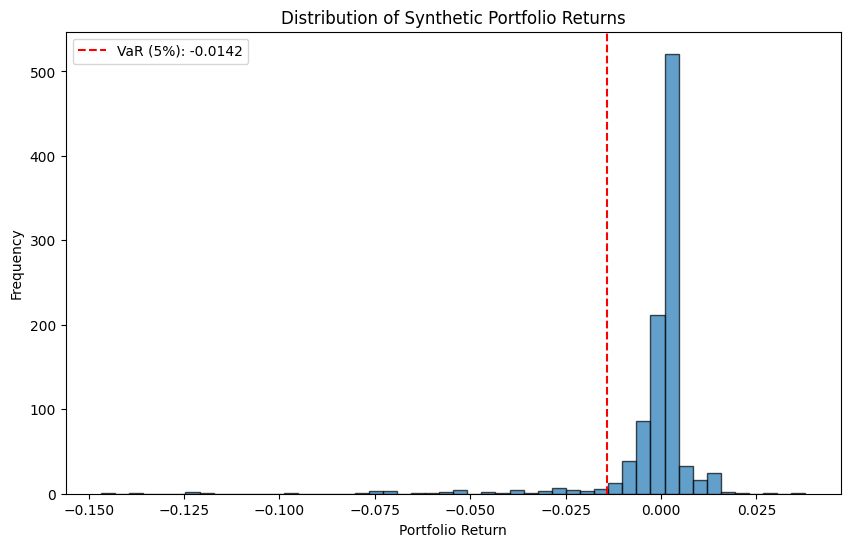

In [18]:
plt.figure(figsize=(10, 6))
plt.hist(synthetic_portfolio_returns, bins=50, alpha=0.7, edgecolor="black")
plt.axvline(
    var_threshold, color="r", linestyle="--", label=f"VaR (5%): {var_threshold:.4f}"
)
plt.xlabel("Portfolio Return")
plt.ylabel("Frequency")
plt.title("Distribution of Synthetic Portfolio Returns")
plt.legend()
plt.show()

### Heatmap of Extreme Scenarios (VaR)

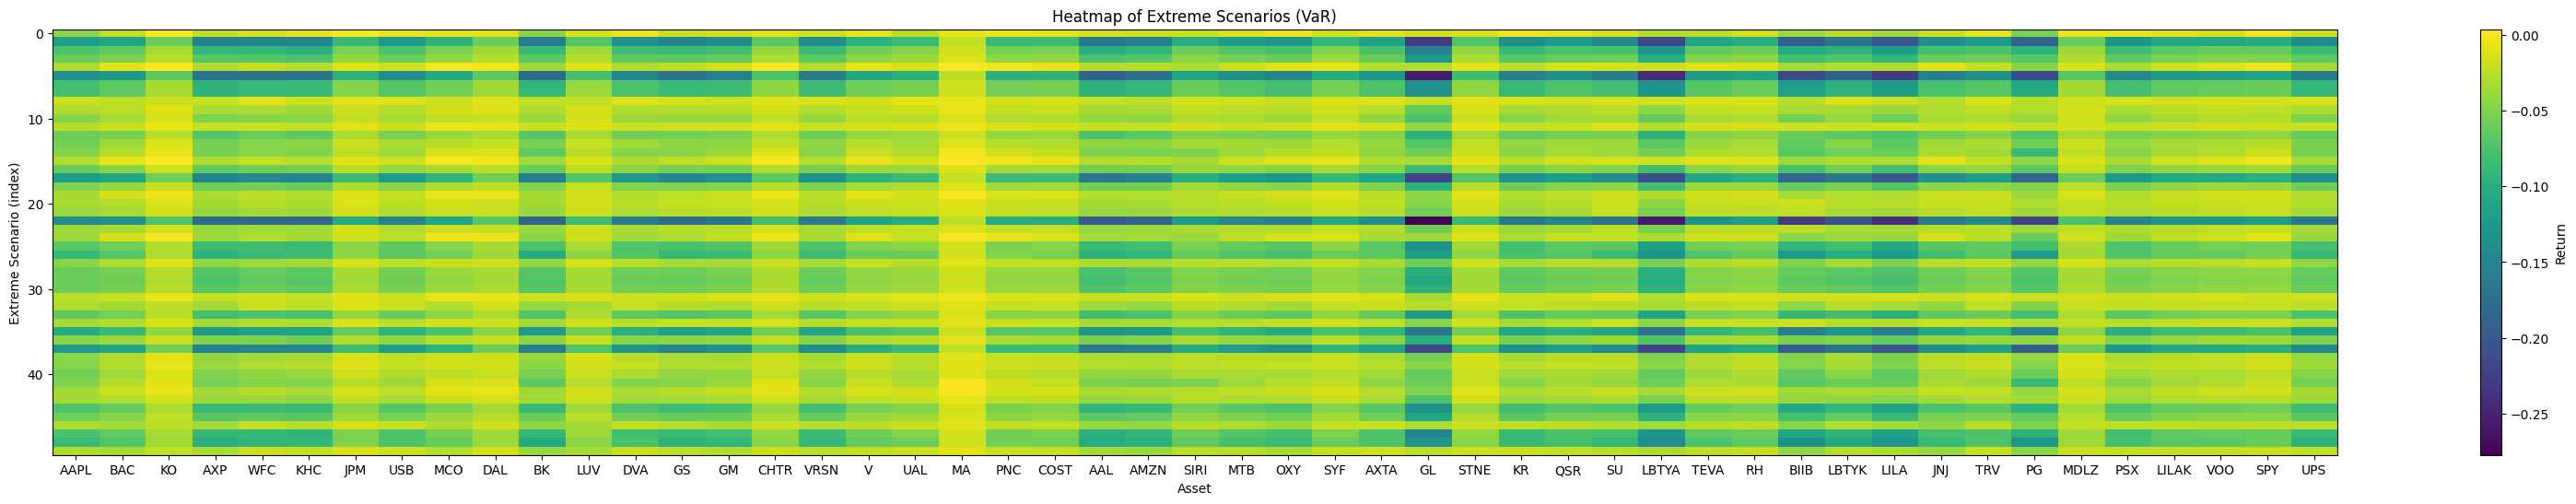

In [23]:
plt.figure(figsize=(40, 6))
plt.imshow(extreme_scenarios, aspect="auto", cmap="viridis")
plt.colorbar(label="Return")
plt.xticks(ticks=np.arange(len(tickers)), labels=tickers)
plt.xlabel("Asset")
plt.ylabel("Extreme Scenario (index)")
plt.title("Heatmap of Extreme Scenarios (VaR)")
plt.show()

### Scatter Plot of Latent Space with Clusters

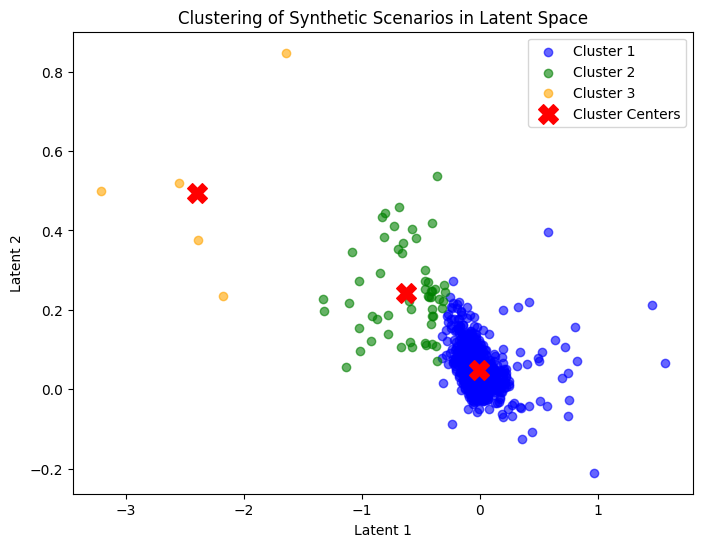

In [ ]:
plt.figure(figsize=(8, 6))

colors = ["blue", "green", "orange"]
cluster_colors = [colors[c] for c in clusters]
for i, color in enumerate(colors):
    plt.scatter(
        generated_latent[clusters == i, 0],
        generated_latent[clusters == i, 1],
        c=color,
        alpha=0.6,
        label=f"Cluster {i+1}",
    )
plt.scatter(
    cluster_centers[:, 0],
    cluster_centers[:, 1],
    c="red",
    marker="X",
    s=200,
    label="Cluster Centers",
)
plt.xlabel("Latent 1")
plt.ylabel("Latent 2")
plt.title("Clustering of Synthetic Scenarios in Latent Space")
plt.legend()
plt.show()